# *Keypoints*

En esta lección experimentaremos con la propiedad visual más importante: los "[puntos de interés](https://en.wikipedia.org/wiki/Interest_point_detection)", y veremos un ejemplo de reconocimiento de objetos usando sus "descriptores".

En el capítulo de flujo óptico vimos que las zonas de la imagen con gradiente en varias direcciones (*corners*) son fácilmente localizables con precisión en imágenes sucesivas. Ahora estamos interesados en zonas aún más específicas, que puedan identificarse en otras vistas de la misma escena aunque se produzcan desplazamientos, rotaciones o cambios de tamaño.

## Bibliotecas y funciones auxiliares

In [1]:
import numpy             as np
import cv2               as cv
import matplotlib.pyplot as plt

%matplotlib inline

def fig(w,h):
    plt.figure(figsize=(w,h))

def readrgb(file):
    return cv.cvtColor( cv.imread("../images/"+file), cv.COLOR_BGR2RGB) 

def rgb2gray(x):
    return cv.cvtColor(x,cv.COLOR_RGB2GRAY)

def gray2float(x):
    return x.astype(float) / 255

# para ver imágenes monocromas autoescalando el rango
def imshowg(x):
    plt.imshow(x, 'gray')

# para ver imágenes monocromas de float con rango fijo
def imshowf(x):
    plt.imshow(x, 'gray', vmin = 0, vmax=1)
    
# para ver imágenes con signo
def imshows(x,r=1):
    plt.imshow(x, 'gray', vmin = -r, vmax=r)

## *Hessian*: detector de no linealidad

Las zonas de la imagen cuya superficie de color o nivel de gris es localmente plana no aportan mucha información. Corresponden a regiones uniformes o que cambian suavemente. Una forma de detectar zonas interesantes es buscar segundas derivadas intensas.

Con el gradiente (primeras derivadas) y el Hessiano (segundas derivadas) construimos un modelo cuadrático de la imagen en un pequeño entorno de cada pixel. Si fuera unidimensional y centrado en el origen sería algo como $I(x)\simeq a+bx+\frac{1}{2}cx^2$. En dos dimensiones:

$$p = \begin{bmatrix}x\\y\end{bmatrix} \;\;\;\; \Delta p = p - p_0$$

$$I(p) \simeq I(p_0) + \nabla I\, \Delta p + \frac{1}{2} \Delta p ^ T \, H \, \Delta p $$

$$\nabla I = \begin{bmatrix}\frac{\partial I}{\partial x}&\frac{\partial I}{\partial y}\end{bmatrix}$$


$$H=\begin{bmatrix}\frac{\partial^2 I}{\partial x^2}&\frac{\partial^2 I}{\partial x\partial y}\\
                   \frac{\partial^2 I}{\partial y\partial x}&\frac{\partial^2 I}{\partial y^2}
\end{bmatrix}$$

A continuación se muestran distintos tipos de modelos locales (para versiones muy suavizadas de la imagen original):

<table border=1>
  <tr>
    <td><img src="../images/demos/quadmod/H3.png" width="160px"/></td>
    <td><img src="../images/demos/quadmod/H4.png" width="160px"/></td>
    <td><img src="../images/demos/quadmod/H5.png" width="160px"/></td>
  </tr><tr>
    <td><img src="../images/demos/quadmod/H1.png" width="160px"/></td>
    <td><img src="../images/demos/quadmod/H2.png" width="160px"/></td>
    <td><img src="../images/demos/quadmod/H6.png" width="160px"/></td>
  </tr>
</table>

En el determinante Hessiano $det(H)$ indica en qué medida es necesario el término cuadrático (no lineal) para modelar localmente la superficie de imagen.

También se podría usar el Laplaciano, pero es menos útil porque su respuesta no permite distinguir bordes intensos de estructuras más localizadas.



Los elementos de $\nabla I$ y $H$ se calculan mediante filtros de derivación.

In [2]:
def grad(x):
    gx = cv.Sobel(x,-1,1,0)/8
    gy = cv.Sobel(x,-1,0,1)/8
    return gx,gy

def grad2(x):
    gx,gy = grad(x)
    gxx,gxy = grad(gx)
    #gxx = cv.Sobel(x,-1,2,0); gxy = cv.Sobel(x,-1,1,1)
    gyy = cv.Sobel(gy,-1,0,1)/8
    #gyy = cv.Sobel(x,-1,0,2)
    return gx,gy,gxx,gyy,gxy

La imagen siempre se analiza a una cierta escala. Para ello se hará un suavizado gaussiano previo.

In [3]:
def gaussian(s,x):
    return cv.GaussianBlur(x,(0,0), s)

Cargamos una imagen de prueba.

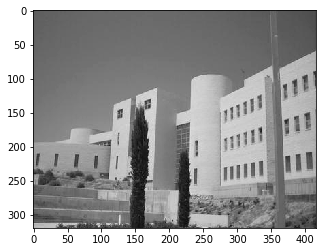

In [4]:
#img = readrgb('d2.jpg')[0:500,0:500]
img = readrgb('pano/pano001.jpg')

x = gray2float(rgb2gray(img))
imshowg(x)

In [5]:
gx,gy,gxx,gyy,gxy = grad2(gaussian(3,x))
h = gxx*gyy-gxy**2

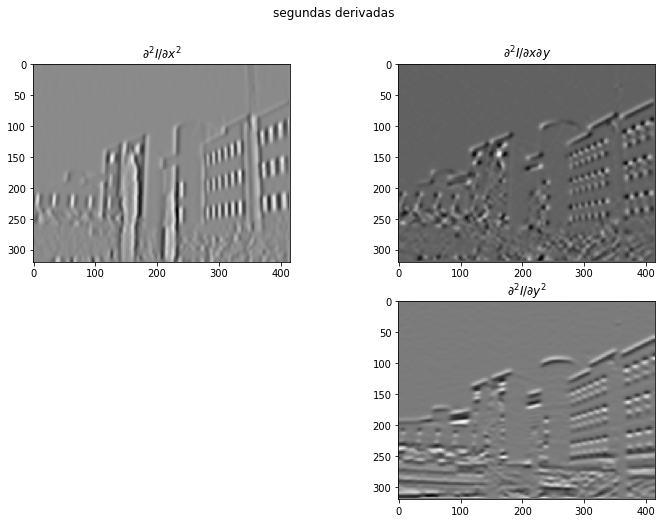

In [6]:
fig(12,8); plt.suptitle('segundas derivadas')
plt.subplot(2,2,1); imshowg(gxx); plt.title('$\\partial ^2 I/ \\partial x^2$')
plt.subplot(2,2,2); imshowg(gxy); plt.title('$\\partial ^2 I/ \\partial x \\partial y$')
plt.subplot(2,2,4); imshowg(gyy); plt.title('$\\partial ^2 I/ \\partial y^2$');

El signo del determinante indica si la zona es una mancha compacta, más clara u oscura que su entorno, (positivo) o un punto de silla (negativo).

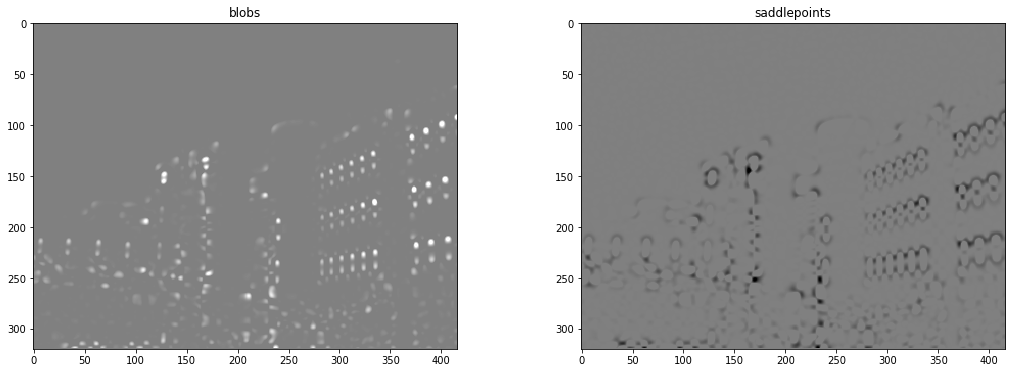

In [7]:
fig(18,6)
plt.subplot(1,2,1)
imshows(np.maximum(0,h),0.0001); plt.title('blobs')
plt.subplot(1,2,2)
imshows(np.minimum(0,h),0.0001); plt.title('saddlepoints');

Una forma rápida de encontrar los máximos del detector (*non maximum supression*) puede ser la siguiente:

In [8]:
def nms(x, t = 0.1):
    m = cv.dilate(x, np.ones((5,5),np.uint8))  # filtro de máximo
    h = np.max(m)
    return (x == m) & (x > t*h)

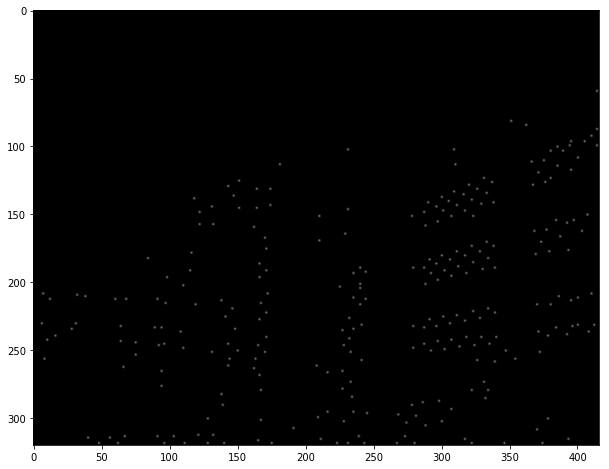

In [9]:
k = nms(-h)
fig(12,8)
#imshowg(k)
plt.imshow(k, 'gray', interpolation='bicubic');

Lo anterior es una imágen booleana. De ella extraemos las coordenadas de los puntos:

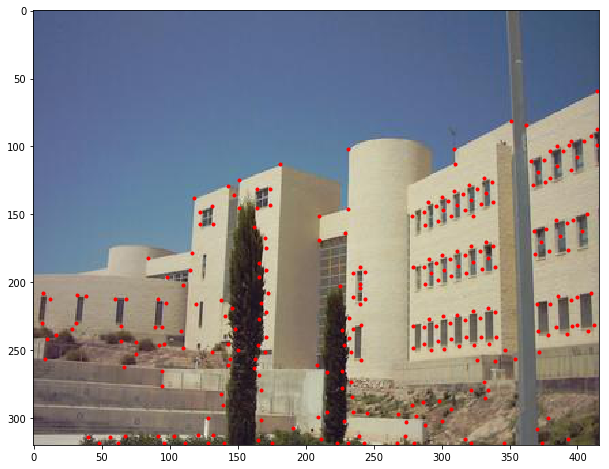

In [10]:
py,px = np.where(k)

fig(12,8)
plt.imshow(img); #ax = plt.axis();
plt.plot(px,py,'.r'); #plt.axis(ax);

Disgresión: los puntos de hessiano grande tienen la información relevante, son zonas no lineales y con ellas se puede reconstruir una versión aproximada de la imagen, de forma parecida a lo que hicimos con los bordes de Canny.

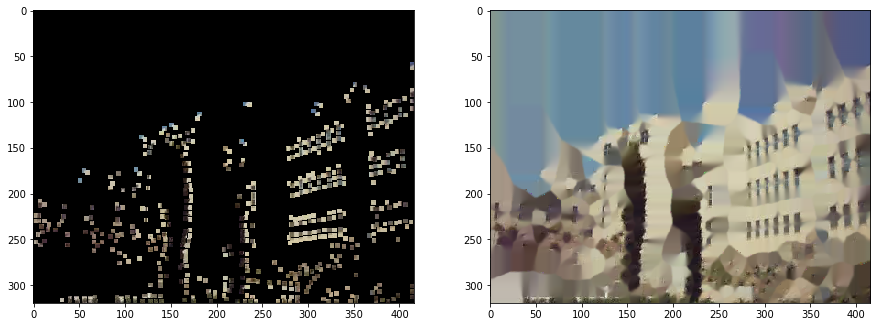

In [11]:
k = nms(abs(h),0.05)

mask = cv.dilate(k.astype(np.uint8), np.ones((5,5),np.uint8))
xx = img.copy()
xx[mask==0] = 0,0,0
dst = cv.inpaint(img,1-mask,3,cv.INPAINT_NS);

fig(15,6)
plt.subplot(1,2,1); plt.imshow(xx);
plt.subplot(1,2,2); plt.imshow(dst);

## Detección automática de escala

La intensidad del detector depende de la escala de análisis.

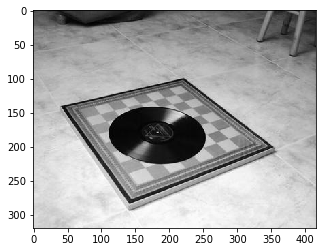

In [12]:
disk = gray2float(rgb2gray(readrgb('disk1.jpg')))

imshowg(disk)

### det Hessian

In [13]:
def hess(x):
    _,_,gxx,gyy,gxy = grad2(x)
    h = gxx*gyy-gxy**2
    return h

In [14]:
mxs = 50
scales = [1.1**k for k in range(-1,mxs+1)]

In [15]:
hs = np.array([hess(gaussian(s,disk)) for s in scales])

from ipywidgets import interactive

def fun(k=17):
    imshows(hs[k],0.00001)
    plt.title('$\sigma={:.1f}$'.format(scales[k]))

interactive(fun, k=(0,mxs))    

interactive(children=(IntSlider(value=17, description='k', max=50), Output()), _dom_classes=('widget-interact',))

Esto sugiere la posibilidad de detectar automáticamente la escala óptima de cada punto (el tamaño de su "área de influencia"). La idea es construir el espacio de escala $(x,y,\sigma)$ de la imagen (una [secuencia de suavizados][1] cada vez mayores) y encontrar los puntos de ese espacio 3D discretizado que son máximos locales (los que tienen una respuesta mayor que sus 9 vecinos).

[1]: https://en.wikipedia.org/wiki/Pyramid_(image_processing)

Es importante normalizar el valor de Hessiano para que tenga respuestas comparables a distintas escalas. Se puede demostrar que la normalización adecuada para el Hessiano es $\sigma^4$ y que se obtendrán máximos locales en objetos redondeados de radio $\sigma \sqrt{2}$. Lo comprobamos con un par de círculos de tamaño conocido.

Text(0.5,1,'radio 30 px')

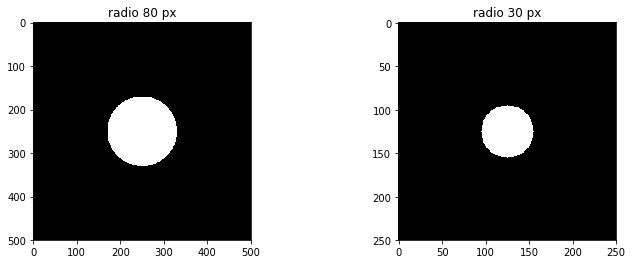

In [16]:
def circle(sz=500, rad=50):
    r = np.arange(-sz//2,sz//2)
    x = r.reshape(-1,1)
    y = r.reshape(1,-1)
    img = x**2 + y**2 <= rad**2
    return img.astype(float)

circle1 = circle(500,80)
circle2 = circle(250,30)

fig(12,4)
plt.subplot(1,2,1); plt.imshow(circle1,'gray'); plt.title('radio 80 px')
plt.subplot(1,2,2); plt.imshow(circle2,'gray'); plt.title('radio 30 px')

rad:  [ 77.44756619  29.85938943]


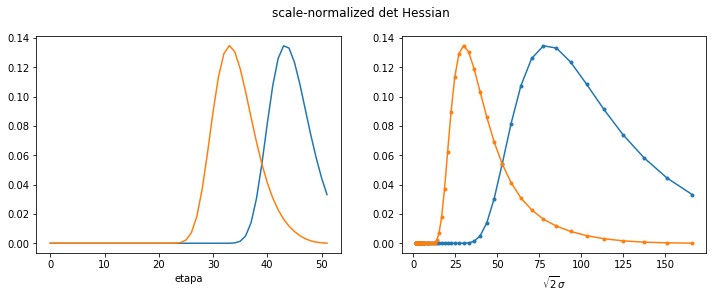

In [17]:
hs1 = np.array([s**4*hess(gaussian(s,circle1))[250,250] for s in scales])
s1 = scales[np.argmax(hs1)]
hs2 = np.array([s**4*hess(gaussian(s,circle2))[125,125] for s in scales])
s2 = scales[np.argmax(hs2)]
print('rad: ',np.sqrt(2)*np.array([s1,s2]))
rads = np.sqrt(2)*np.array(scales)
fig(12,4)
plt.subplot(1,2,1)
plt.plot(hs1)
plt.plot(hs2); plt.xlabel('etapa');
plt.subplot(1,2,2)
plt.plot(rads,hs1,'.-')
plt.plot(rads,hs2,'.-'); plt.xlabel('$\sqrt{2}\sigma$');
plt.suptitle('scale-normalized det Hessian');

Los tamaños se detectan muy bien, teniendo en cuenta que la escala está discretizada.

Mediante este procedimiento vamos detectar los círculos de la imagen siguiente:

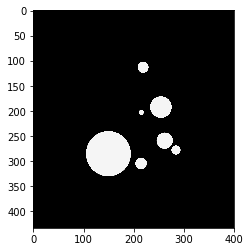

In [18]:
circles = cv.resize(readrgb('circles.jpg'),(0,0), fx=0.1, fy=0.1)
circles = 1-np.pad(gray2float(rgb2gray(circles)),100,mode='constant',constant_values=1)

x = circles
imshowg(x)

In [19]:
hs = np.array([s**4*hess(gaussian(s,x)) for s in scales])

from ipywidgets import interactive

def fun(k):
    imshows(hs[k],r=0.05)
    plt.title('$\sigma={:.1f}$'.format(scales[k]))

interactive(fun, k=(0,mxs))    

interactive(children=(IntSlider(value=25, description='k', max=50), Output()), _dom_classes=('widget-interact',))

Mostramos los extremos más intensos:

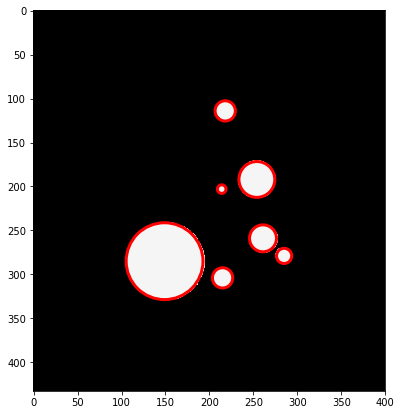

In [20]:
import scipy.ndimage

ks = scipy.ndimage.maximum_filter(hs,3)

S,R,C = np.where((ks==hs) & (hs >0.05))
#print(S,R,C)

fig(7,7)
imshowg(x)
ax = plt.gca()
for s,r,c in zip(S,R,C):
        ax.add_patch(plt.Circle((c,r), np.sqrt(2)*scales[s],color='red',fill=False,lw=3));

La detección es excelente. En imágenes naturales no hay círculos perfectos, pero se detectarán "blobs" (manchas más o menos redondeadas) de diferentes tamaños.

### Laplacian

Veamos la respuesta del Laplaciano, que es un detector más simple de no linealidad en la imagen.

In [21]:
def lap(x):
    _,_,gxx,gyy,_ = grad2(x)
    l = gxx + gyy
    return l

La normalización de Laplaciano es $\sigma^2$.

In [22]:
Ls = np.array([s**2*lap(gaussian(s,x)) for s in scales])

from ipywidgets import interactive

def fun(k):
    imshows(Ls[k],r=0.5)
    plt.title('$\sigma={:.1f}$'.format(scales[k]))

interactive(fun, k=(0,mxs))    

interactive(children=(IntSlider(value=25, description='k', max=50), Output()), _dom_classes=('widget-interact',))

De nuevo, mostramos los extremos más intensos. En este caso nos fijamos en los mínimos, dado que los "blobs" son negros sobre fondo blanco. Si fuera al revés, seleccionaríamos máximos locales. (El determinante Hessiano positivo detecta ambos tipos de blobs, mientras que el negativo detecta los puntos de silla).

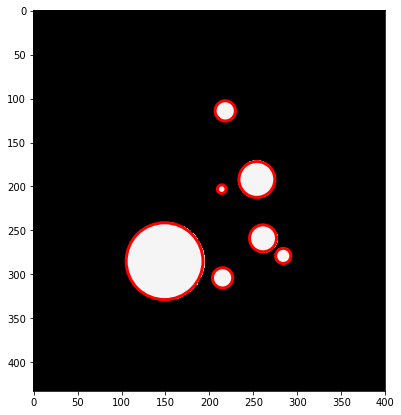

In [23]:
ks = scipy.ndimage.minimum_filter(Ls,3)

S,R,C = np.where((ks==Ls) & (Ls <-0.3))

fig(7,7)
imshowg(x)
ax = plt.gca()
for s,r,c in zip(S,R,C):
        ax.add_patch(plt.Circle((c,r), np.sqrt(2)*scales[s],color='red',fill=False,lw=3));

La detección es igual de precisa y el radio tiene la misma relación con la escala de máxima respuesta.

### DoG

Finalmente, vamos a calcular una aproximación al Laplaciano computacionalmente eficiente, basada en la diferencia de niveles consecutivos de suavizado. Es el operador [DoG](https://en.wikipedia.org/wiki/Blob_detection#The_difference_of_Gaussians_approach).

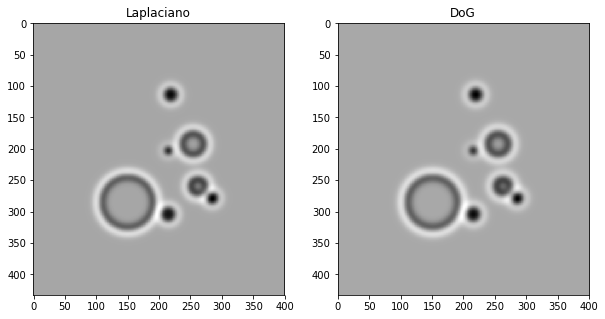

In [24]:
sigma = 6
deltasigma = 1

s1 = gaussian(sigma,x)
s2 = gaussian(sigma+deltasigma, x)

al = (s2-s1)*sigma/deltasigma
l = lap(gaussian(sigma,x))*sigma**2

fig(10,5)
plt.subplot(1,2,1); plt.imshow(l,'gray'); plt.title('Laplaciano')
plt.subplot(1,2,2); plt.imshow(al,'gray'); plt.title('DoG');

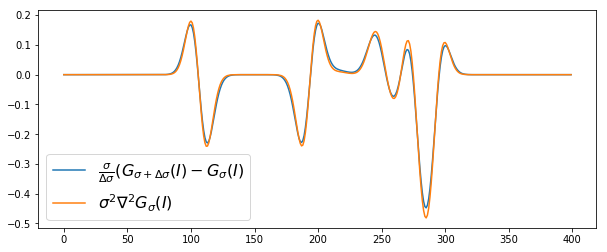

In [25]:
fig(10,4)
plt.plot(al[275],label='$\\frac{\sigma}{\Delta \sigma}(G_{\sigma + \Delta \sigma}(I) - G_{\sigma}(I)$')
plt.plot(l[275], label='$\sigma^2 \\nabla^2 G_\sigma(I)$');
plt.legend(fontsize=16);

Creamos el espacio de escala. Para que el proceso sea más eficiente habría que ir reduciendo la imagen de tamaño, pero nosotros ahora no lo hacemos para poder comparar las etapas de forma directa.

In [26]:
mxs = 20
scales = [1.4**k for k in range(-1,mxs+1)]

In [27]:
pyr = np.array([gaussian(s,x) for s in scales])

In [28]:
def fun(k=7):
    plt.imshow(pyr[k],'gray',vmin=pyr.min(),vmax=pyr.max());
    plt.title('$\sigma={:.1f}$'.format(scales[k]))

interactive(fun, k=(0,mxs))    

interactive(children=(IntSlider(value=7, description='k', max=20), Output()), _dom_classes=('widget-interact',))

Ahora calculamos las diferencias entre ellas. Gracias a que las escalas van aumentando de forma exponencial el factor de ajuste $\sigma/\Delta\sigma$ es constante.

In [29]:
f = 1/(1.4-1)

dog = np.array([(xa-x)*f for x,xa in zip(pyr,pyr[1:])])

In [30]:
def fun(k=7):
    plt.imshow(dog[k],'gray',vmin=dog.min(),vmax=dog.max());
    plt.title('$\sigma={:.1f}$'.format(scales[k]))

interactive(fun, k=(0,mxs))    

interactive(children=(IntSlider(value=7, description='k', max=20), Output()), _dom_classes=('widget-interact',))

In [31]:
ks = scipy.ndimage.minimum_filter(dog,3)

In [32]:
S,R,C = np.where((ks==dog) & (abs(dog) >0.3))
S,R,C

(array([ 4,  6,  7,  7,  8,  9, 11]),
 array([203, 279, 114, 304, 259, 192, 285]),
 array([214, 285, 218, 215, 261, 254, 149]))

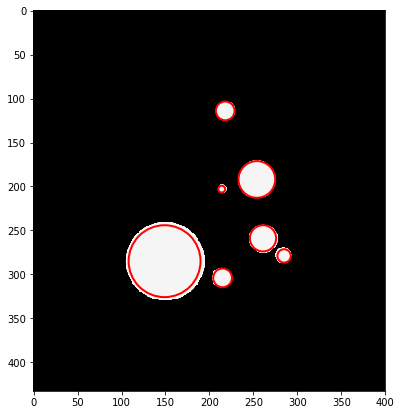

In [33]:
fig(7,7)
imshowg(x)
ax = plt.gca()
for s,r,c in zip(S,R,C):
        ax.add_patch(plt.Circle((c,r), np.sqrt(2)*scales[s],color='red',fill=False,lw=2));

A medida que $\Delta \sigma$ aumenta la detección de tamaño pierde algo de precisión pero el resultado es muy aceptable.

- [ejemplo](https://www.nature.com/articles/s41598-018-19379-x)

- [automatic scale selection](https://ags.cs.uni-kl.de/fileadmin/inf_ags/opt-ss14/OPT_SS2014_lec03.pdf)

## SIFT: *scale invariant feature transform*

Es uno de los [métodos más conocidos](https://en.wikipedia.org/wiki/Scale-invariant_feature_transform) para extraer puntos de interés. Obtiene puntos característicos con una escala y orientación, y con un *descriptor* de apariencia que permite calcular coincidencias entre puntos de diferentes imágenes. Esto permite resolver muchos problemas de visión artificial, tanto de reconocimiento de objetos como de geometría visual. La detección se basa en máximos locales del determinante Hessiano en el espacio de escala aprovechando el método DoG anterior, y el descriptor es un histograma de gradientes orientados HOG muy parecido al que ya hemos estudiado, tomado en una región de imagen del tamaño indicado por la escala del punto y rotado en la dirección dominante.

OpenCV proporciona un implementación de SIFT. Para calcular a la vez los puntos y los descriptores usamos `detectAndCompute`. Los puntos son estructuras con los campos que se muestran en el siguiente trozo de código, y los descriptores se devuelven como filas de un array. El número de puntos y su intensidad se controla con los argumentos de [SIFT_create](https://docs.opencv.org/3.4/d5/d3c/classcv_1_1xfeatures2d_1_1SIFT.html).

In [34]:
sift = cv.xfeatures2d.SIFT_create(nfeatures=0, contrastThreshold = 0.04)

kp,desc = sift.detectAndCompute(img, mask=None)

xs = [ p.pt[0] for p in kp]
ys = [ p.pt[1] for p in kp]
sc = [ p.size  for p in kp]
rs = [ p.angle for p in kp]

print(len(kp))
print(desc.shape)

619
(619, 128)


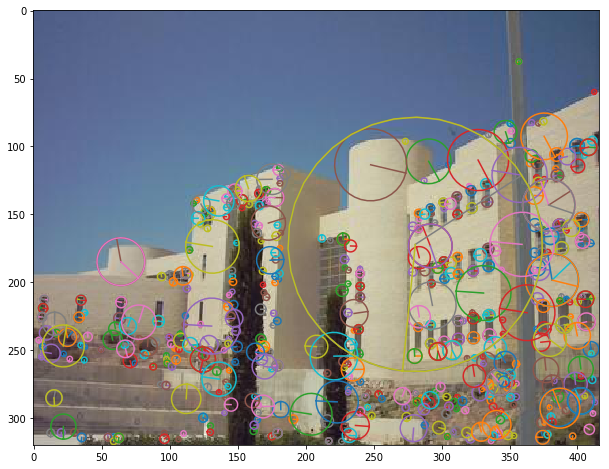

In [35]:
# para mostrar un keypoint en matplotlib, con su tamaño y orientación
def shkeypoint(k):
    t = np.linspace(k.angle,360+k.angle,36)*np.pi/180
    xs = k.pt[0]+k.size*np.cos(t)
    ys = k.pt[1]+k.size*np.sin(t)
    plt.plot(np.append(k.pt[0],xs),np.append(k.pt[1],ys))

fig(12,8)
plt.imshow(img); ax = plt.axis();
for k in kp:
    if k.size > 0:
        shkeypoint(k)
plt.axis(ax);

Veamos los puntos SIFT de la imagen de círculos anterior. Esta vez usamos la utilidad que proporciona OpenCV para dibujar los puntos.

30


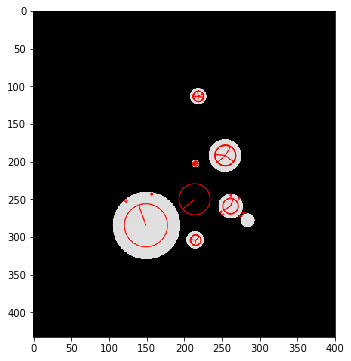

In [36]:
circ = rgb2gray(cv.resize(readrgb('circles.jpg'),(0,0), fx=0.1, fy=0.1))
circ = 255-cv.cvtColor(np.pad(circ,100,mode='constant',constant_values=255), cv.COLOR_GRAY2BGR)

kp, desc = sift.detectAndCompute(circ, mask=None)
flag = cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
cv.drawKeypoints(circ,kp,circ, color=(255,0,0), flags=flag)

fig(6,6)
print(len(kp))
plt.imshow(circ,'gray');

Parece que el `.size` calculado se refiere al $\sigma$ óptimo del blob, no al radio del "círculo equivalente".

### Image matching using keypoints

Una aplicación directa es el reconocimiento de objetos: la similitud de dos imágenes se puede medir con el número de keypoints coincidentes (que tienen descriptores muy parecidos).

La carpeta sift/models contiene buenas imágenes de tres cuadros de Vermeer. En la carpeta sift/tests hay fragmentos de esas obras tomadas de cualquier manera con la webcam.

In [37]:
import glob
def readfiles(path):
    return [readrgb(file) for file in sorted(glob.glob('../images/'+path))]

imgs = readfiles('sift/tests/*.*')
mods = readfiles('sift/models/*.*')

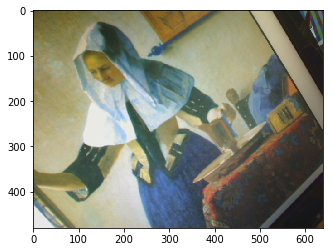

In [38]:
plt.imshow(imgs[1]);

Calculamos los puntos SIFT de todas las imágenes:

In [39]:
sift = cv.xfeatures2d.SIFT_create()

dis = [sift.detectAndCompute(x,None) for x in imgs]
dms = [sift.detectAndCompute(x,None) for x in mods]

Las coincidencias de keypoints entre dos imágenes se calculan con un ["matcher"](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_matcher/py_matcher.html) y luego se filtran para dejar solo las que que no tengan ambigüedad. Una forma de hacer esto es el *ratio test*: se descartan los puntos cuya mejor coincidencia es parecida a la segunda mejor. Para conseguir esta información usamos el método *knn* (k-*nearest neigbors*) del *matcher*.

In [40]:
# por fuerza bruta
bf = cv.BFMatcher()


# fast approximate nearest neighbor
# pip install opencv-contrib-python

#FLANN_INDEX_KDTREE = 0
#index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
#search_params = dict(checks=50)   # or pass empty dictionary
#flann = cv.FlannBasedMatcher(index_params,search_params)

modelo: 38266,  imagen: 415
coincidencias: 3 (0.7%)


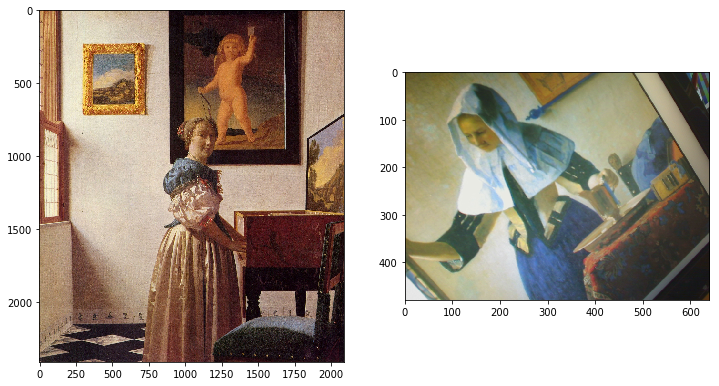

In [41]:
m = 2  # model
t = 1  # target

print('modelo: {},  imagen: {}'.format(len(dms[m][1]), len(dis[t][1])))

fig(12,8)
plt.subplot(1,2,1); plt.imshow(mods[m]);
plt.subplot(1,2,2); plt.imshow(imgs[t]);

#                     query      model    num de vecinos
matches = bf.knnMatch(dis[t][1],dms[m][1],k=2)
#matches = flann.knnMatch(dis[t][1],dms[m][1],k=2)    

# ratio test
good = []
for mt in matches:
    if len(mt) == 2:
        best, second = mt
        if best.distance < 0.75*second.distance:
            good.append(best)        
        
        
print('coincidencias: {} ({:.1f}%)'.format(len(good),100*len(good)/len(dis[t][1])))

Cambiando el modelo `m` y la imagen de prueba `t` podemos comprobar que el número de puntos coincidentes o su proporción puede servir para reconocer objetos con suficiente textura. 

Los *matchings* contienen el grado de coincidencia y los índices de los puntos de interés de la imagen desconocida y del modelo.

In [42]:
matching = good[0]

matching.distance

137.4299774169922

In [43]:
matching.queryIdx

2

In [44]:
matching.trainIdx

36237

La función `cv.drawMatches` representa gráficamente las posiciones de los puntos coincidentes.

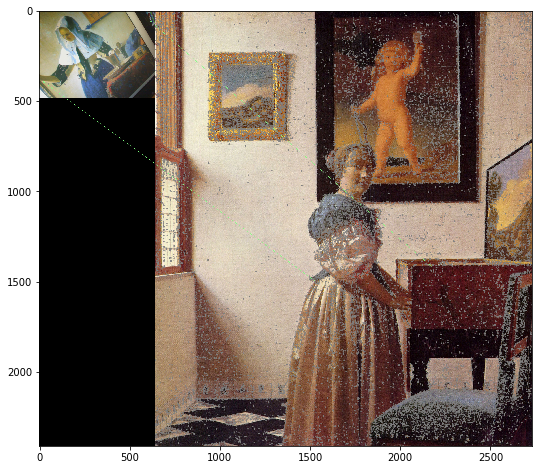

In [45]:
fig(12,8)
plt.imshow(cv.drawMatches(imgs[t], dis[t][0], mods[m], dms[m][0], good,
                      flags=0,
                      matchColor=(128,255,128),
                      singlePointColor = (128,128,128),
                      outImg=None) );

### Otros *Keypoints* disponibles en OpenCV

OpenCV tiene muchos otros detectores de *keypoints*, que suelen utilizarse con un interfaz común.

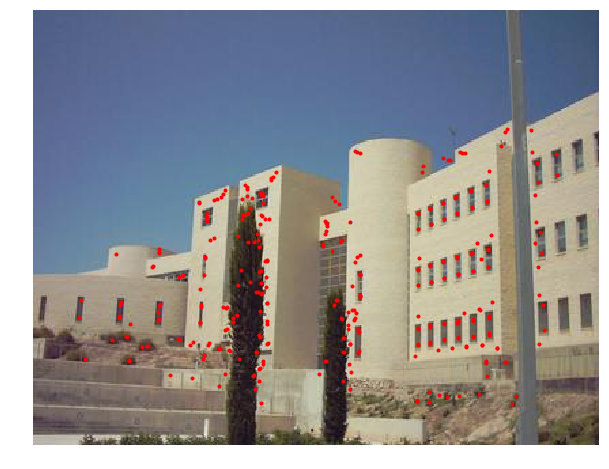

In [46]:
#method = cv.xfeatures2d.StarDetector_create()
#method = cv.FastFeatureDetector_create()
#method = cv.ORB_create()
#method = cv.xfeatures2d.SIFT_create()
#method = cv.xfeatures2d.SURF_create()
method = cv.AKAZE_create()

kp = method.detect(img)

xs = [ p.pt[0] for p in kp]
ys = [ p.pt[1] for p in kp]

fig(12,8)
plt.imshow(img); ax = plt.axis('off');
plt.plot(xs,ys,'.r'); plt.axis(ax);

Dependiendo de las necesidades de nuestra aplicación (velocidad de cálculo vs estabilidad de los puntos) elegiremos el más adecuado.

## *Bag of visual words*

Cuando hay muchos modelos la búsqueda de coincidencias en todos ellos puede ser muy costosa. Una forma de acelerar el proceso es construir un "[vocabulario visual](https://en.wikipedia.org/wiki/Bag-of-words_model_in_computer_vision)" a partir de una gran colección de keypoints extraídos de los modelos disponibles o de escenas parecidas (mediante [k-means](https://en.wikipedia.org/wiki/K-means_clustering) o algún método parecido). Cada imagen se representa mediante un histograma que contabiliza el número de ocurrencias de cada "visual word". Este histograma sirve como *feature* para comparar las imágenes o para entrenar un clasificador. ([Csurka 2004](https://www.cs.cmu.edu/~efros/courses/LBMV07/Papers/csurka-eccv-04.pdf)).

## Animación

In [47]:
from matplotlib import animation, rc
rc('animation', html='html5')

In [48]:
testimage = circles
#testimage = gray2float(rgb2gray(imgs[0]))

scales = [1.02**(k-1) for k in range(15*20)]
Ls = np.array([s**2*lap(gaussian(s,testimage)) for s in scales])

Gs = np.array([gaussian(s,testimage) for s in scales])

ks1 = scipy.ndimage.minimum_filter(Ls,3)

S1,R1,C1 = np.where((ks1==Ls) & (Ls < -0.15))

ks2 = scipy.ndimage.maximum_filter(Ls,3)

S2,R2,C2 = np.where((ks2==Ls) & (Ls > 0.15))

In [51]:
len(S1),len(S2)

(30, 540)

In [59]:
fig = plt.figure(figsize=(6.4,4.8))
ax = fig.add_axes([0,0,1,1])
ax.set_axis_off()

modo = 'L'
rL = 0.4

uL = -0.3
uH = 10

if modo == 'G':
    def fun(k):
        return cv.GaussianBlur(testimage,(0,0),scales[k])
    simg = ax.imshow(fun(0),'gray',vmin =0, vmax= 1);

if modo == 'L':
    def fun(k):
        return Ls[k]
    simg = ax.imshow(fun(0),'coolwarm',vmin = -rL, vmax= rL); 

stext = ax.text(30,30,'$\sigma$',color='red',fontsize=15);
stext.set_visible(True)
plt.close()

def animate(k):
    simg.set_data(fun(k))
    stext.set_text(f'$\sigma = {scales[k]:.1f}$')
    
    for s,r,c in zip(S1,R1,C1):
        if s==k and Ls[s,r,c] < uL:
            ax.add_patch(plt.Circle((c,r), np.sqrt(2)*scales[s],color='blue',fill=False,lw=1));
    for s,r,c in zip(S2,R2,C2):
        if s==k and Ls[s,r,c] > uH:
            ax.add_patch(plt.Circle((c,r), np.sqrt(2)*scales[s],color='red',fill=False,lw=1));
    
    return [simg]

fps=20
T = 13
animation.FuncAnimation(fig, animate, init_func=lambda:[], frames=T*fps, interval=1000/fps, blit=True, repeat=False)